In [1]:
import os
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from sklearn.metrics import mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score,roc_curve,auc, f1_score, roc_auc_score,confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
import seaborn as sns

In [3]:
os.chdir("/")
! dir


bin	 dev   lib32  NGC-DL-CONTAINER-LICENSE	root  sys    var
boot	 etc   lib64  opt			run   tmp
content  home  media  proc			sbin  tools
datalab  lib   mnt    python-apt		srv   usr


In [6]:
! unzip "/content/drive/MyDrive/Colab Notebooks/Exo_planets_detection_data/archive.zip"


Archive:  /content/drive/MyDrive/Colab Notebooks/Exo_planets_detection_data/archive.zip
  inflating: exoTest.csv             
  inflating: exoTrain.csv            


In [7]:
test_data = pd.read_csv('exoTest.csv').fillna(0)
train_data = pd.read_csv('exoTrain.csv').fillna(0)
train_data.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [8]:
categ = {2: 1,1: 0}
train_data.LABEL = [categ[item] for item in train_data.LABEL]
test_data.LABEL = [categ[item] for item in test_data.LABEL]

Text(0.5, 1.0, 'Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)')

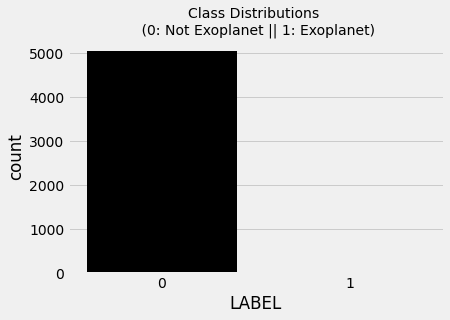

In [10]:
plt.figure(figsize=(6,4))
colors = ["0", "1"]
sns.countplot('LABEL', data=train_data, palette=colors)
plt.title('Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)', fontsize=14)

In [16]:
#Reduce memory
def reduce_memory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return end_mem
    
    #Output

In [17]:
    dftest_data = reduce_memory(test_data)


Memory usage of dataframe is 6.25 MB
Memory usage after optimization is: 6.25 MB
Decreased by 0.0%


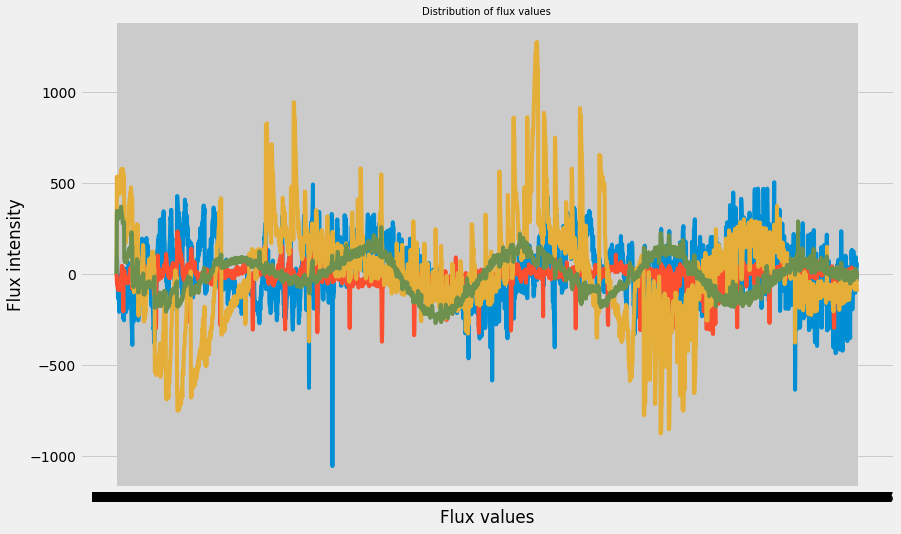

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 8
plt.title('Distribution of flux values', fontsize=10)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')
plt.plot(train_data.iloc[0,])
plt.plot(train_data.iloc[1,])
plt.plot(train_data.iloc[2,])
plt.plot(train_data.iloc[3,])
plt.show()

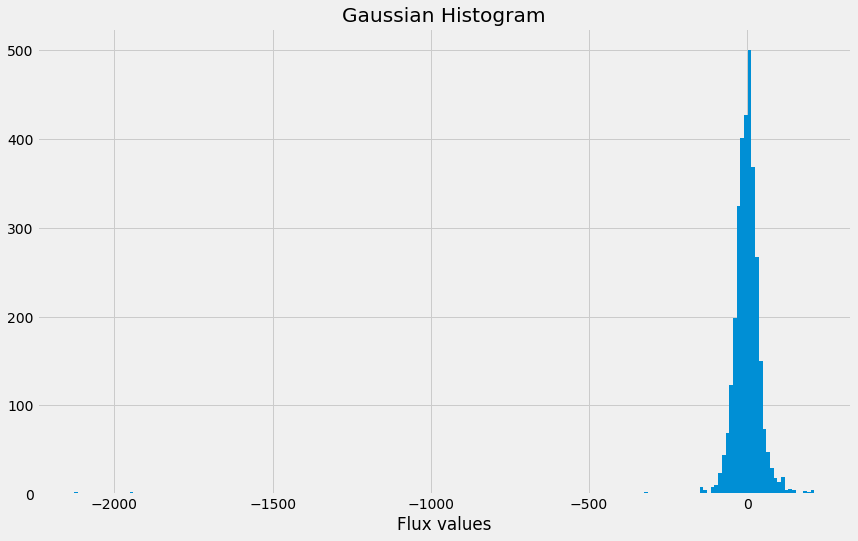

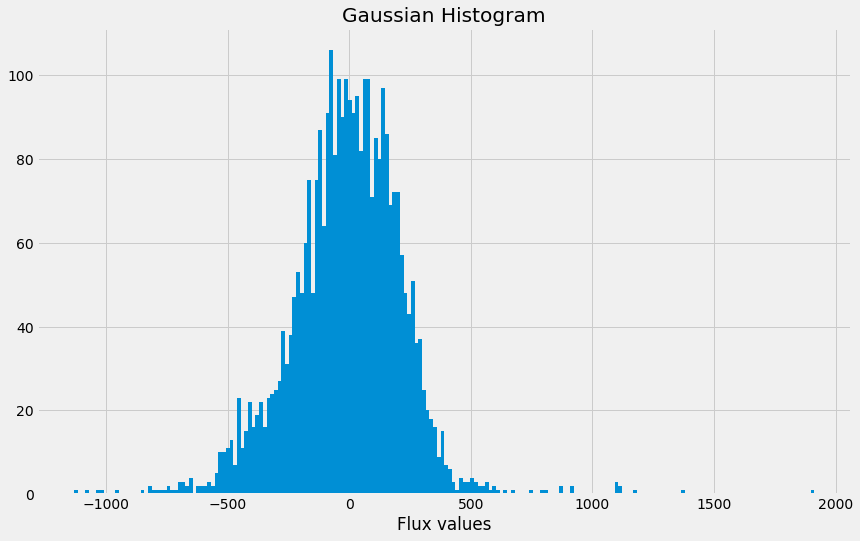

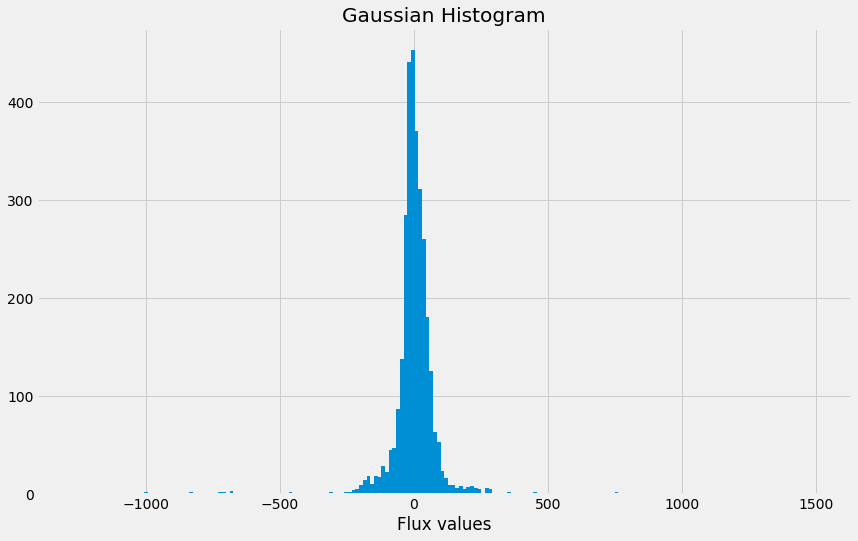

In [19]:
labels_1=[100,200,300]
for i in labels_1:
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

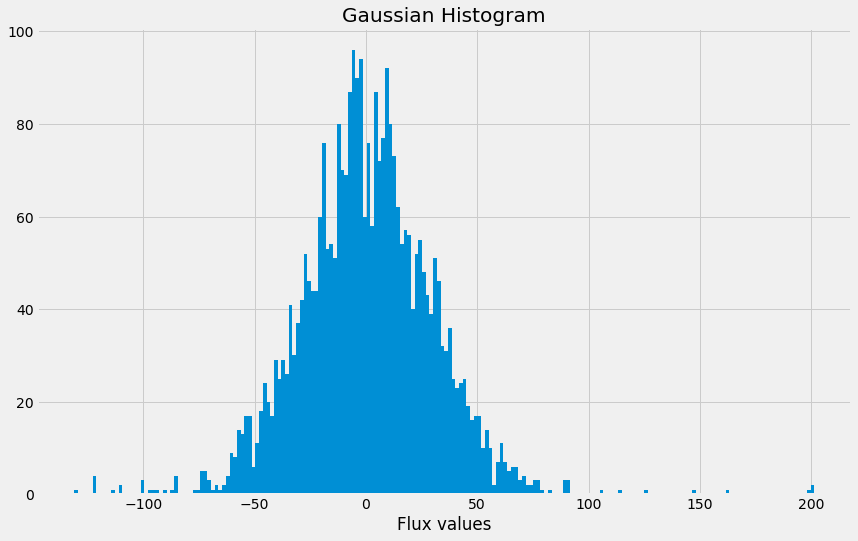

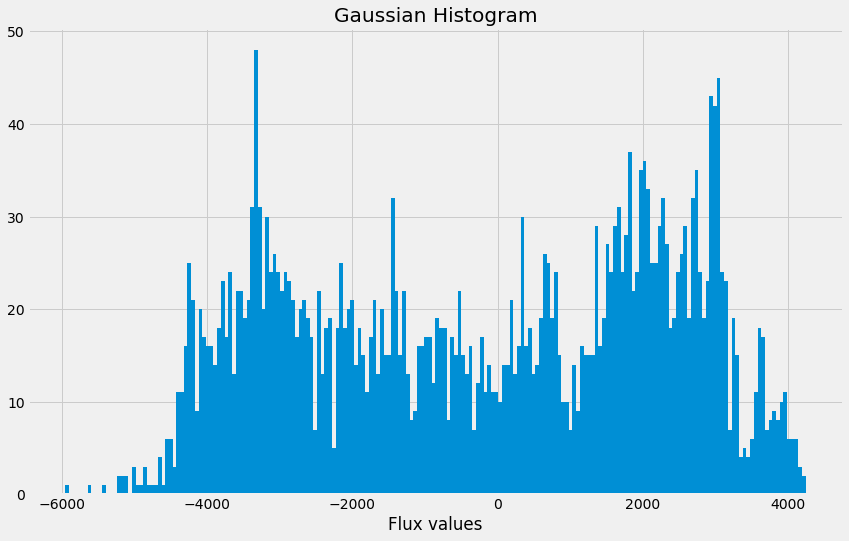

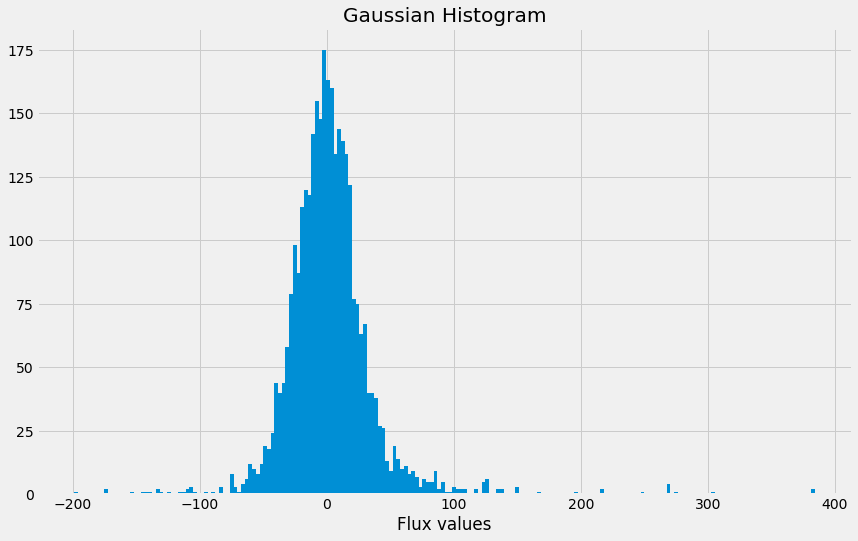

In [20]:
labels_1=[16,21,25]
for i in labels_1:
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

In [21]:
x_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]   
x_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

In [22]:
x_train = normalized = normalize(x_train)
x_test = normalize(x_test)

In [23]:
x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)

In [28]:
#Dimentioanlity reduction
from sklearn.decomposition import PCA
pca = PCA() 
X_train = pca.fit_transform(x_train)
X_test = pca.transform(x_test)
total=sum(pca.explained_variance_)
k=0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1

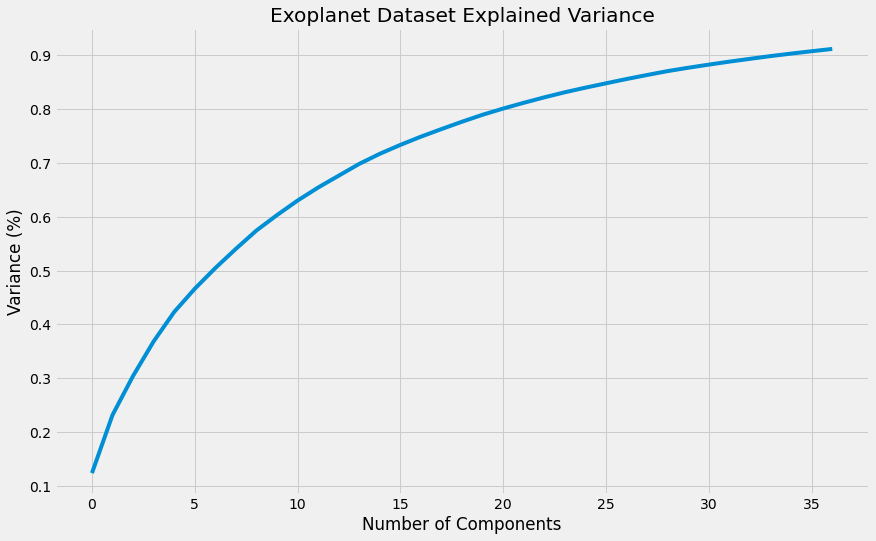

In [29]:
#Apply PCA with n_componenets
pca = PCA(n_components=37)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Exoplanet Dataset Explained Variance')
plt.show()

In [35]:
#Resampling
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))
sm = SMOTE()
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel())
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))


Before OverSampling, counts of label '1': 37
Before OverSampling, counts of label '0': 5050 

After OverSampling, counts of label '1': 5050
After OverSampling, counts of label '0': 5050


In [37]:
def model(classifier,dtrain_x,dtrain_y,dtest_x,dtest_y):
    #fit the model
    classifier.fit(dtrain_x,dtrain_y)
    predictions = classifier.predict(dtest_x)
    
    #Cross validation
    accuracies = cross_val_score(estimator = classifier, X = x_train_res, y = y_train_res, cv = 5, n_jobs = -1)
    mean = accuracies.mean()
    variance = accuracies.std()
    print("Accuracy mean: "+ str(mean))
    print("Accuracy variance: "+ str(variance))
    
    #Accuracy
    print ("\naccuracy_score :",accuracy_score(dtest_y,predictions))
    
    #Classification report
    print ("\nclassification report :\n",(classification_report(dtest_y,predictions)))
    
    #Confusion matrix
    plt.figure(figsize=(13,10))
    plt.subplot(221)
    sns.heatmap(confusion_matrix(dtest_y,predictions),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
    plt.title("CONFUSION MATRIX",fontsize=20)

Accuracy mean: 0.9992079207920792
Accuracy variance: 0.0015841584158415856

accuracy_score : 0.9912280701754386

classification report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



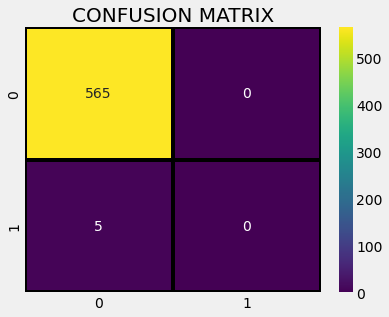

In [38]:
from sklearn.svm import SVC
SVM_model=SVC()
model(SVM_model,x_train_res,y_train_res,x_test,y_test)


In [41]:
#Display feature importance  

def model(classifier,dtrain_x,dtrain_y,dtest_x,dtest_y):
    #fit the model
    classifier.fit(dtrain_x,dtrain_y)
    predictions = classifier.predict(dtest_x)
    
    #Cross validation
    accuracies = cross_val_score(estimator = classifier, X = x_train_res, y = y_train_res, cv = 5, n_jobs = -1)
    mean = accuracies.mean()
    variance = accuracies.std()
    print("Accuracy mean: "+ str(mean))
    print("Accuracy variance: "+ str(variance))
    
    #Accuracy
    print ("\naccuracy_score :",accuracy_score(dtest_y,predictions))
    
    #Classification report
    print ("\nclassification report :\n",(classification_report(dtest_y,predictions)))
    
    #Confusion matrix
    plt.figure(figsize=(13,10))
    plt.subplot(221)
    sns.heatmap(confusion_matrix(dtest_y,predictions),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
    plt.title("CONFUSION MATRIX",fontsize=20)

# added for RF model

    df1 = pd.DataFrame.from_records(dtrain_x)     
    tmp = pd.DataFrame({'Feature': df1.columns, 'Feature importance': classifier.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (7,4))
    plt.title('Features importance',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()

Accuracy mean: 0.9999009900990099
Accuracy variance: 0.0001980198019801982

accuracy_score : 0.9912280701754386

classification report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



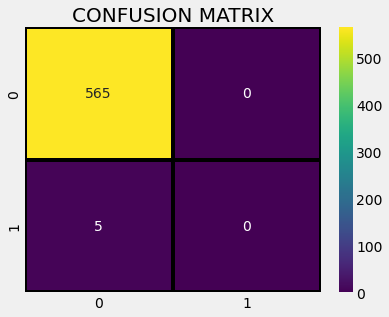

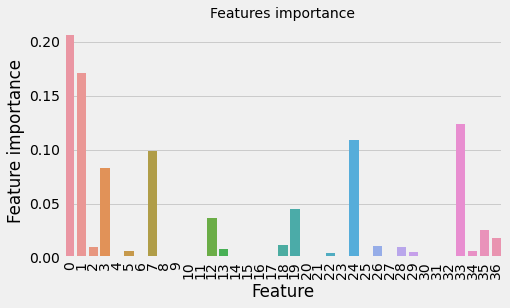

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier()
model(rf_classifier,x_train_res,y_train_res,x_test,y_test)

In [46]:
# from tensorflow import set_random_seed

import tensorflow

tensorflow.random.set_seed(101)

 
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential # initialize neural network library
from keras.layers import Dense # build our layers library
def build_classifier():
    classifier = Sequential() # initialize neural network
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu', input_dim = x_train_res.shape[1]))
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
    
classifier = KerasClassifier(build_fn = build_classifier, epochs = 40)



accuracies = cross_val_score(estimator = classifier, X = x_train_res, y = y_train_res, cv = 5, n_jobs = -1)
mean = accuracies.mean()
variance = accuracies.std()
print("Accuracy mean: "+ str(mean))
print("Accuracy variance: "+ str(variance))#Accuracy mean: 0.9186138613861387
#Accuracy variance: 0.07308084375906461


Accuracy mean: 0.6958415806293488
Accuracy variance: 0.401521294121656
